Model: DecisionTreeClassifier
Best Parameters: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_split': 2}
Confusion Matrix:
[[383  64]
 [  1   0]]
Precision: 0.9951695033482143, Recall: 0.8549107142857143, F1-Score: 0.9197234399174833
ROC AUC Score: 0.32885906040268453
_______________________________________________________________

_______________________________________________________________
Model: RandomForestClassifier
Best Parameters: {'model__class_weight': 'balanced', 'model__max_depth': 5, 'model__n_estimators': 100}
Confusion Matrix:
[[419  28]
 [  1   0]]
Precision: 0.9953922193877551, Recall: 0.9352678571428571, F1-Score: 0.9643938457736037
ROC AUC Score: 0.3355704697986577
_______________________________________________________________

_______________________________________________________________
Model: SVC
Best Parameters: {'model__C': 10, 'model__kernel': 'linear'}
Confusion Matrix:
[[263 184]
 [  0   1]]
Precision: 0.9977799227799228, Recall:

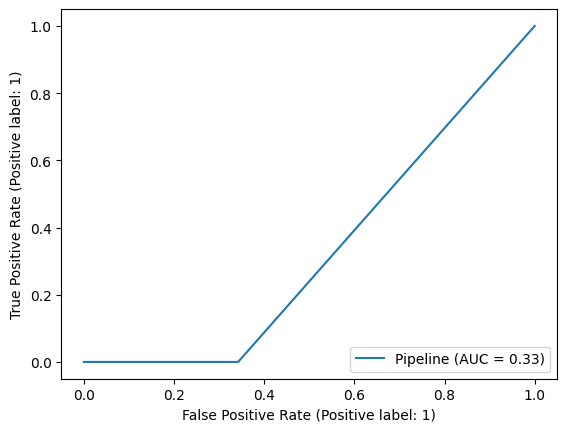

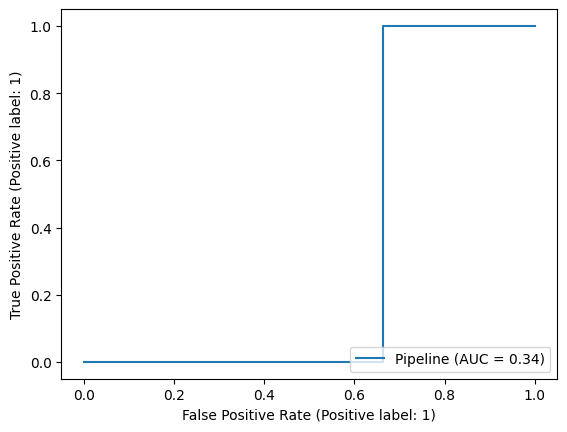

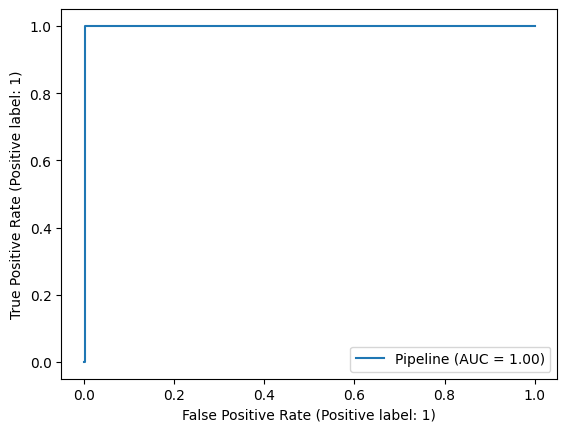

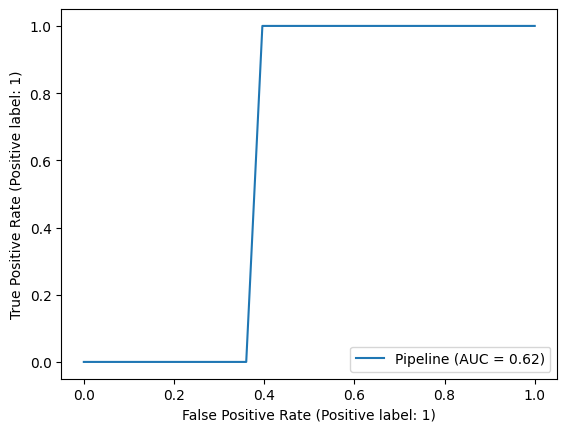

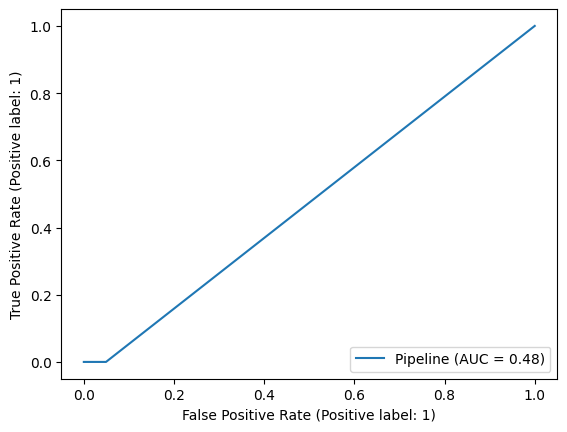

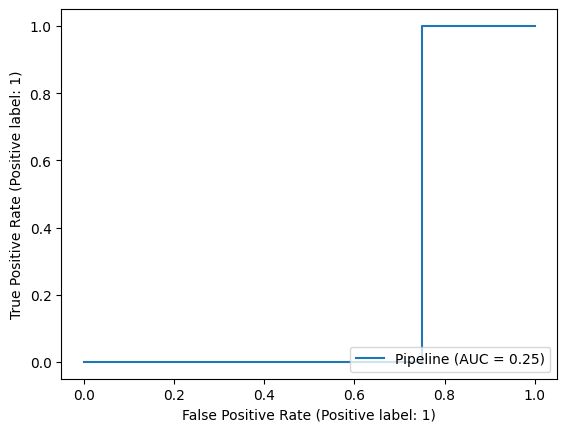

In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier  # Ensure XGBoost is correctly imported
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE




# Load dataset
data = pd.read_csv("./marketing_campaign.csv", delimiter="\t")

# Total spending and Age features
data["Total_Spent"] = data[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]].sum(axis=1)
data['Age'] = 2023 - data['Year_Birth']

# Target variable
y = data["Complain"]

# Define preprocessing for numerical columns
numerical_cols = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Total_Spent', 'Age'] 
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns
categorical_cols = ['Education', 'Marital_Status'] 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Complain', 'Dt_Customer', 'ID', 'Year_Birth'], axis=1), y, test_size=0.2, random_state=42)

# List of models to train
classifiers = [
    (DecisionTreeClassifier(), {'model__max_depth': [3, 5, 10], 'model__min_samples_split': [2, 5, 10], 'model__criterion': ['gini', 'entropy']}),
    (RandomForestClassifier(), {'model__n_estimators': [100, 200, 500], 'model__max_depth': [3, 5, 10], 'model__class_weight': ['balanced']}),
    (SVC(probability=True), {'model__C': [0.1, 1, 10], 'model__kernel': ['linear']}),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 5, 7], 'model__n_estimators': [100, 200]}),
    (KNeighborsClassifier(), {'model__n_neighbors': [3, 5, 7], 'model__metric': ['euclidean', 'manhattan']}),
    (MLPClassifier(), {'model__hidden_layer_sizes': [(10,), (20,)], 'model__max_iter': [1000]})
]

for clf, param_grid in classifiers:
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('model', clf)])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=10), scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    cm = confusion_matrix(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Model: {best_model.named_steps['model'].__class__.__name__}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")
    print(f"ROC AUC Score: {roc_auc}")
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(best_model, X_test, y_test)
    print("_______________________________________________________________\n\n_______________________________________________________________")
